In [2]:

import os
import ee
import geemap
import requests
import leafmap
import numpy as np
import pandas as pd
import geopandas as gpd
import concurrent.futures
import matplotlib.pyplot as plt
from shapely.geometry import box  
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import concurrent.futures
import ee
import requests
from tqdm import tqdm


Area in square meters: 655,930,012,677.30 m²
Area in square kilometers: 655,930.01 km²


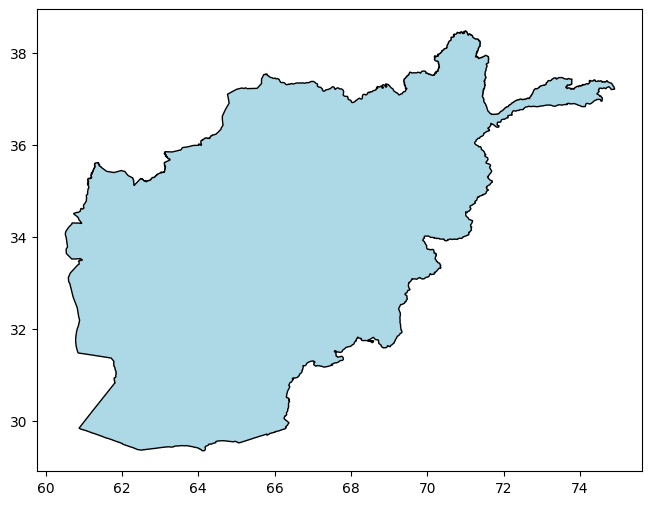

In [3]:
region="afghanistan"
save_path=f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/raw_data/setinel_tiles/{region}"
os.makedirs(save_path, exist_ok=True)
data_path = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/regions/shapes/{region}.geojson"

gdf=gpd.read_file(data_path)
# print(gdf.head())
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, color='lightblue', edgecolor='black')
gdf_projected = gdf.to_crs(epsg=32643)
gdf['area_m2'] = gdf_projected.area
gdf['area_km2'] = gdf['area_m2'] / (1000**2)
print(f"Area in square meters: {gdf['area_m2'].iloc[0]:,.2f} m²")
print(f"Area in square kilometers: {gdf['area_km2'].iloc[0]:,.2f} km²")


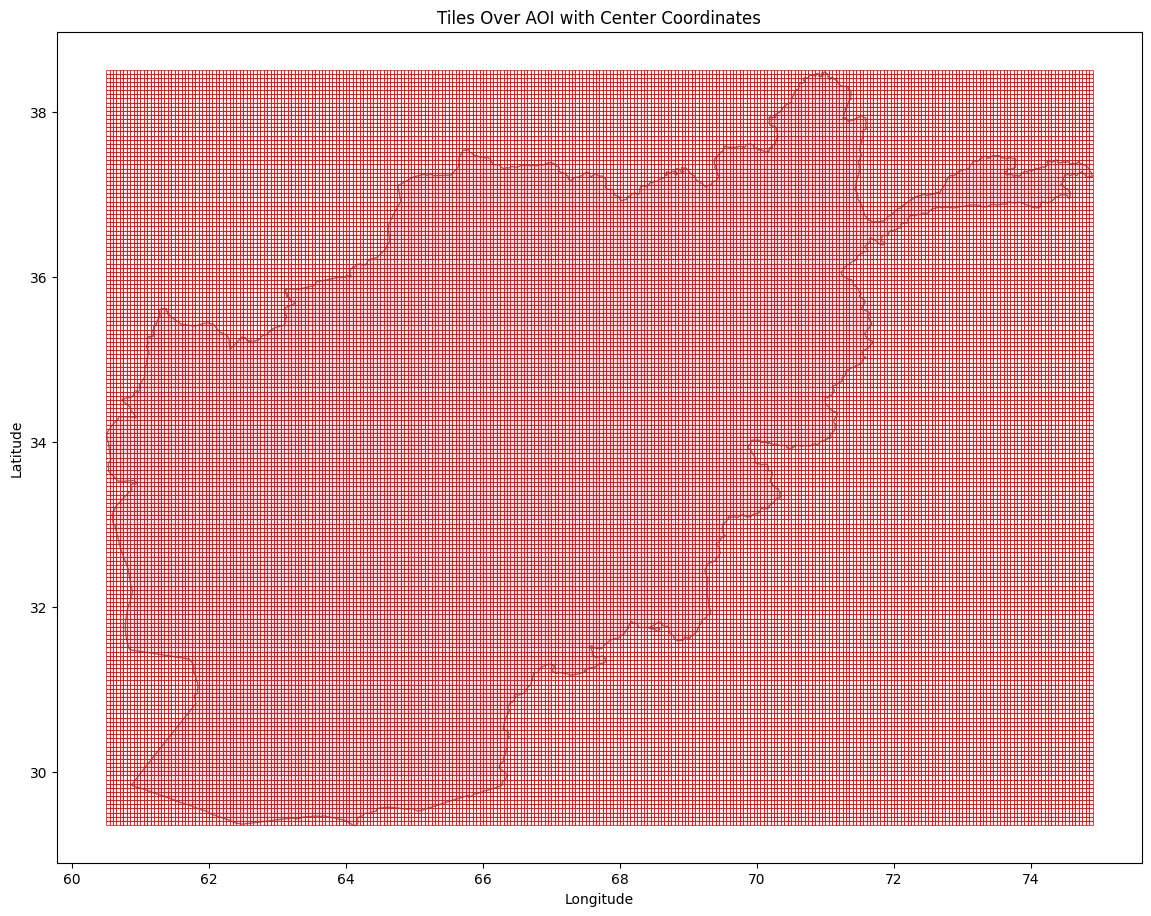

In [4]:


# bounds of the AOI (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = gdf.total_bounds
grid_size = 0.05  # Tile size in degrees
lons = np.arange(minx, maxx, grid_size)
lats = np.arange(miny, maxy, grid_size)
tiles = []
center_coords = []
for lon in lons:
    for lat in lats:
        tile_geometry = box(lon, lat, lon + grid_size, lat + grid_size)
        tile = gpd.GeoDataFrame({'geometry': [tile_geometry]}, crs='EPSG:4326')
        tiles.append(tile)
        center_lon = lon + grid_size / 2
        center_lat = lat + grid_size / 2
        center_coords.append((center_lon, center_lat))

tiles_gdf = gpd.GeoDataFrame(pd.concat(tiles, ignore_index=True), crs='EPSG:4326')
tiles_gdf['center_coordinates'] = center_coords
fig, ax = plt.subplots(figsize=(14, 12))
gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)
tiles_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)
# for idx, row in tiles_gdf.iterrows():
#     center_lon, center_lat = row.center_coordinates
#     ax.annotate(f"{center_lon:.2f},{center_lat:.2f}", (center_lon, center_lat), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=6, color='blue')
plt.title('Tiles Over AOI with Center Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Generated 52704 tiles.
Area of AOI: 62.75 square meters
Filtered 25692 tiles based on intersection area.
Filtered tiles:                   tile_name  intersection_area
85     Tile_60.5049_33.6116           0.000495
86     Tile_60.5049_33.6616           0.001284
87     Tile_60.5049_33.7116           0.001309
88     Tile_60.5049_33.7616           0.000151
90     Tile_60.5049_33.8616           0.000384
...                     ...                ...
52495  Tile_74.8049_37.2116           0.002304
52496  Tile_74.8049_37.2616           0.002418
52497  Tile_74.8049_37.3116           0.000925
52678  Tile_74.8549_37.2116           0.001407
52679  Tile_74.8549_37.2616           0.000518

[25692 rows x 2 columns]
Total number of filtered tiles: 25692
Estimated total file size: 84783.60 MB
Estimated total memory required: 82.80 GB


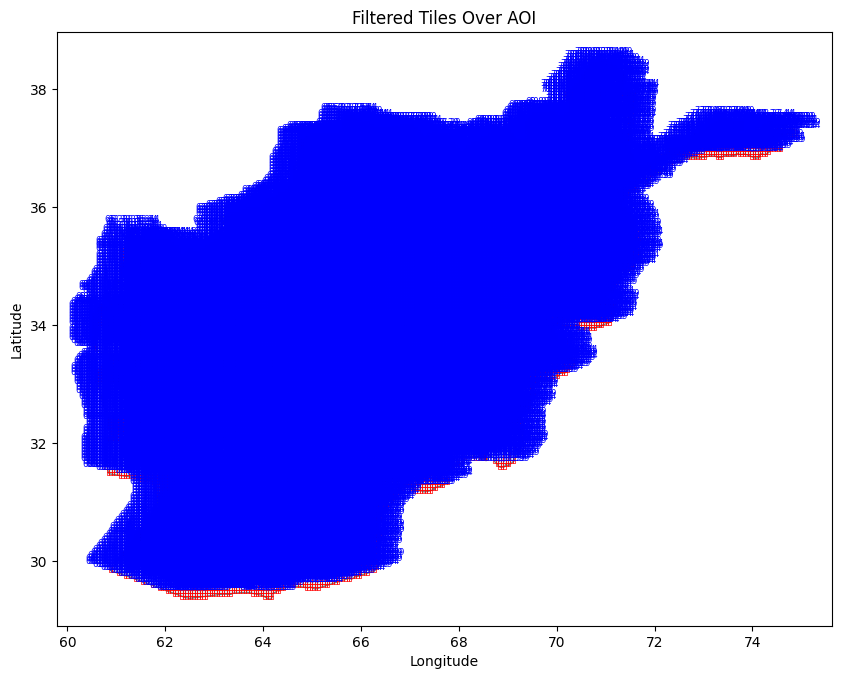

In [5]:


# Create tiles
tiles = []
tiles_names = []
center_coords = []

for lon in lons:
    for lat in lats:
        tile_geometry = box(lon, lat, lon + grid_size, lat + grid_size)
        tile = gpd.GeoDataFrame({'geometry': [tile_geometry]}, crs='EPSG:4326')
        tiles.append(tile)

        # Create tile name and center coordinates
        tile_name = f"Tile_{lon:.4f}_{lat:.4f}"
        tiles_names.append(tile_name)

        center_lon = lon + grid_size / 2
        center_lat = lat + grid_size / 2
        center_coords.append((center_lon, center_lat))

print(f"Generated {len(tiles)} tiles.")

# Combine into a single GeoDataFrame
tiles_gdf = gpd.GeoDataFrame(pd.concat(tiles, ignore_index=True), crs='EPSG:4326')
tiles_gdf['tile_name'] = tiles_names
tiles_gdf['center_coordinates'] = center_coords
tiles_gdf['area_m2'] = tiles_gdf.geometry.area

# Area of AOI
aoi_area = gdf.area.sum()
print(f"Area of AOI: {aoi_area:.2f} square meters")

# Extract tile center and corners
def extract_tile_details(gdf):
    tile_details = []
    for _, row in gdf.iterrows():
        bounds = row.geometry.bounds
        center_x = (bounds[0] + bounds[2]) / 2
        center_y = (bounds[1] + bounds[3]) / 2
        corners = {
            'top_left': (bounds[0], bounds[3]),
            'top_right': (bounds[2], bounds[3]),
            'bottom_left': (bounds[0], bounds[1]),
            'bottom_right': (bounds[2], bounds[1])
        }
        tile_details.append({
            'tile_name': row.tile_name,
            'center_coordinates': (center_x, center_y),
            'corner_coordinates': corners
        })
    return tile_details

tile_details_df = pd.DataFrame(extract_tile_details(tiles_gdf))

# print(tile_details_df)

# Sentinel-2 band info
sentinel2_bands = {
    "B2": {"name": "Blue", "resolution": 10, "central_wavelength": 490},
    "B3": {"name": "Green", "resolution": 10, "central_wavelength": 560},
    "B4": {"name": "Red", "resolution": 10, "central_wavelength": 665},
    "B8": {"name": "NIR", "resolution": 10, "central_wavelength": 842},
    "B11": {"name": "SWIR1", "resolution": 20, "central_wavelength": 1610},
    "B12": {"name": "SWIR2", "resolution": 20, "central_wavelength": 2190},
}

# Add band info to tiles
for band_name, band_info in sentinel2_bands.items():
    tile_details_df[f"{band_name}_resolution"] = band_info['resolution']
    tile_details_df[f"{band_name}_central_wavelength"] = band_info['central_wavelength']

# Intersection and filtering
tiles_gdf['intersection_area'] = tiles_gdf.intersection(gdf.unary_union).area
threshold_area = 0.015 * grid_size * grid_size
filtered_tiles_gdf = tiles_gdf[tiles_gdf['intersection_area'] > threshold_area]
print(f"Filtered {len(filtered_tiles_gdf)} tiles based on intersection area.")

print(f"Filtered tiles: {filtered_tiles_gdf[['tile_name', 'intersection_area']]}")

# Extract tile details again for filtered tiles
filtered_tile_details_df = pd.DataFrame(extract_tile_details(filtered_tiles_gdf))

# Add band info again
for band_name, band_info in sentinel2_bands.items():
    filtered_tile_details_df[f"{band_name}_resolution"] = band_info['resolution']
    filtered_tile_details_df[f"{band_name}_central_wavelength"] = band_info['central_wavelength']

# Merge filtered tile details with filtered tiles_gdf
filtered_tiles_gdf['tile_details'] = filtered_tile_details_df.apply(lambda row: {
    'tile_name': row.tile_name,
    'center_coordinates': row.center_coordinates,
    'corner_coordinates': row.corner_coordinates,
    'B2_resolution': row.B2_resolution,
    'B2_central_wavelength': row.B2_central_wavelength,
    'B3_resolution': row.B3_resolution,
    'B3_central_wavelength': row.B3_central_wavelength,
    'B4_resolution': row.B4_resolution,
    'B4_central_wavelength': row.B4_central_wavelength,
    'B8_resolution': row.B8_resolution,
    'B8_central_wavelength': row.B8_central_wavelength,
    'B11_resolution': row.B11_resolution,
    'B11_central_wavelength': row.B11_central_wavelength,
    'B12_resolution': row.B12_resolution,
    'B12_central_wavelength': row.B12_central_wavelength
}, axis=1)

# Save to GeoJSON
output_path = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/raw_data/sentinel_metadata/{region}_sentinel_metadata.geojson"
filtered_tiles_gdf.to_crs('EPSG:4326').to_file(output_path, driver='GeoJSON')

# Stats
num_tiles = len(filtered_tiles_gdf)
average_file_size_mb = 3.30
total_file_size_mb = num_tiles * average_file_size_mb
total_memory_gb = total_file_size_mb / 1024

print(f"Total number of filtered tiles: {num_tiles}")
print(f"Estimated total file size: {total_file_size_mb:.2f} MB")
print(f"Estimated total memory required: {total_memory_gb:.2f} GB")

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)
filtered_tiles_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)

# Annotate center coordinates if available
if 'center_coordinates' in filtered_tiles_gdf.columns:
    for idx, row in filtered_tiles_gdf.iterrows():
        if isinstance(row['center_coordinates'], tuple):
            center_lon, center_lat = row['center_coordinates']
            ax.annotate(f"{center_lon:.2f},{center_lat:.2f}", (center_lon, center_lat), textcoords="offset points",
                        xytext=(0, 5), ha='center', fontsize=6, color='blue')

plt.title('Filtered Tiles Over AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Number of filtered tiles: 2178


<Axes: >

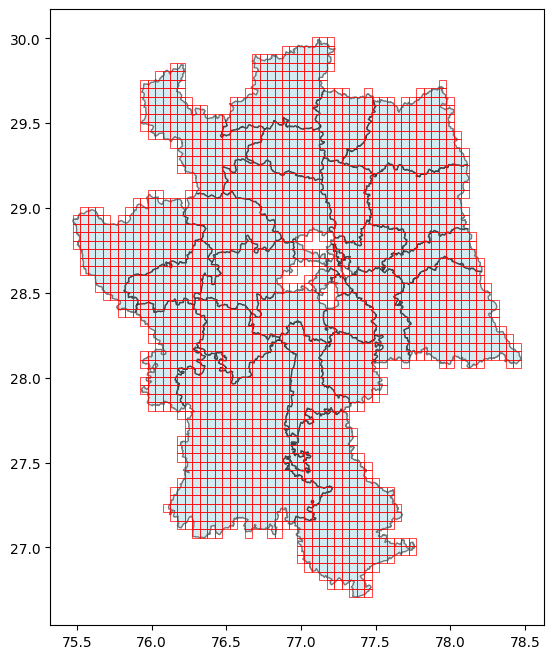

In [9]:
# Load the GeoJSON file
gdf = gpd.read_file(data_path)

# Get bounds of the AOI (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = gdf.total_bounds

# Parameters for tile generation
grid_size = 0.05  # Tile size in degrees
lons = np.arange(minx, maxx, grid_size)
lats = np.arange(miny, maxy, grid_size)


# Create a list to store tiles
tiles = []
center_coords = []
for lon in lons:
    for lat in lats:
        # Use shapely.geometry.box() to create tiles
        tile_geometry = box(lon, lat, lon + grid_size, lat + grid_size)
        tile = gpd.GeoDataFrame({'geometry': [tile_geometry]}, crs='EPSG:4326')
        tiles.append(tile)

        # Calculate center coordinates
        center_lon = lon + grid_size / 2
        center_lat = lat + grid_size / 2
        center_coords.append((center_lon, center_lat))


# Combine tiles into a single GeoDataFrame
tiles_gdf = gpd.GeoDataFrame(pd.concat(tiles, ignore_index=True), crs='EPSG:4326')
tiles_gdf['center_coordinates'] = center_coords       


# Calculate intersection area between each tile and AOI
tiles_gdf['intersection_area'] = tiles_gdf.intersection(gdf.unary_union).area

# Filter out tiles with very small intersection areas
threshold_area = 0.030 * grid_size * grid_size  # Set threshold as 1.5% of tile area (adjust as needed)
filtered_tiles_gdf = tiles_gdf[tiles_gdf['intersection_area'] > threshold_area]


# Print the number of filtered tiles
print(f"Number of filtered tiles: {len(filtered_tiles_gdf)}")

#plot the filtered tiles
fig, ax = plt.subplots(figsize=(10, 8))

gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)
filtered_tiles_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)

In [10]:
m = leafmap.Map(center=[(miny + maxy) / 2, (minx + maxx) / 2], zoom=12)
m.add_basemap("SATELLITE")  # Add satellite basemap

# Add AOI to the map
m.add_gdf(gdf, layer_name='AOI', style={'color': 'blue', 'fillColor': 'lightblue', 'fillOpacity': 0.0})

# Add filtered tiles to the map
m.add_gdf(filtered_tiles_gdf, layer_name='Filtered Tiles', style={'color': 'red', 'fillOpacity': 0})

# Display the map
m

Map(center=[28.349750696319653, 76.97543662892323], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [19]:
import ee

# Initialize Earth Engine
ee.Initialize()


In [ ]:
# import os
# import requests
# import ee
# import rasterio
# from rasterio.errors import RasterioIOError
# from tqdm import tqdm

# ee.Initialize()

# # Function to mask clouds
# def mask_clouds(image):
#     qa = image.select('QA60').uint16()  # Ensure it's an integer
#     cloud_mask = qa.bitwiseAnd(1 << 10).eq(0)  # Identify non-cloud pixels
#     return image.updateMask(cloud_mask)

# # Function to download a single tile
# def download_tile(tile_geometry, tile_name, save_path):
#     try:
#         ee_tile = ee.Geometry.Polygon(list(tile_geometry.exterior.coords))

#         # Get the best available image
#         image_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
#             .filterBounds(ee_tile) \
#             .filterDate('2024-01-01', '2025-02-28') \
#             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 1)) \
#             .select(['B4', 'B3', 'B2', 'B8', 'B11', 'B12', 'QA60']) \
#             .sort('CLOUDY_PIXEL_PERCENTAGE')

#         # Try the least cloudy image first
#         best_image = image_collection.first().clip(ee_tile)
#         best_image = mask_clouds(best_image)

#         # Use median image as backup
#         backup_image = image_collection.median().clip(ee_tile)
#         backup_image = mask_clouds(backup_image)

#         # Compute valid pixel counts
#         valid_pixels_best = ee.Number(best_image.reduceRegion(
#             reducer=ee.Reducer.count(),
#             geometry=ee_tile,
#             scale=10
#         ).values().get(0))

#         valid_pixels_backup = ee.Number(backup_image.reduceRegion(
#             reducer=ee.Reducer.count(),
#             geometry=ee_tile,
#             scale=10
#         ).values().get(0))

#         # Select the image with more valid pixels
#         final_image = ee.Algorithms.If(valid_pixels_best.gt(valid_pixels_backup), best_image, backup_image)

#         # Generate download URL
#         url = ee.Image(final_image).getDownloadURL({
#             'scale': 10,
#             'region': ee_tile.getInfo(),
#             'format': 'GEO_TIFF'
#         })

#         # Download the image
#         response = requests.get(url)
#         with open(f'{save_path}/{tile_name}.tif', 'wb') as f:
#             f.write(response.content)

#         print(f"Downloaded {tile_name}")

#     except Exception as e:
#         print(f"Skipping {tile_name}: {str(e)}")

# # Function to check if a downloaded .tif file is valid
# def check_tif_file(file_path, min_size_mb=1):
#     """Check if the downloaded .tif file exists, is not empty, and is a valid GeoTIFF."""
#     if not os.path.exists(file_path):
#         return False

#     # Check if the file size is greater than a reasonable threshold (e.g., 1 MB)
#     if os.path.getsize(file_path) < min_size_mb * 1024 * 1024:  # 1 MB threshold
#         print(f"File is too small: {file_path}")
#         return False

#     # Check if the file is a valid GeoTIFF using rasterio
#     try:
#         with rasterio.open(file_path) as ds:
#             if ds.count < 1:
#                 print(f"Invalid raster (no bands): {file_path}")
#                 return False
#         return True
#     except rasterio.errors.RasterioIOError:
#         print(f"Invalid GeoTIFF file: {file_path}")
#         return False

# # Function to handle download and validation sequentially
# def download_and_validate_tile(tile_geometry, tile_name, save_path):
#     tile_path = os.path.join(save_path, f'{tile_name}.tif')
    
#     # Download the tile
#     download_tile(tile_geometry, tile_name, save_path)
    
#     # Check if the downloaded file is valid
#     if check_tif_file(tile_path):
#         print(f"Tile {tile_name} is valid.")
#     else:
#         print(f"Tile {tile_name} is invalid, re-downloading...")
#         # Re-download the tile if invalid
#         download_tile(tile_geometry, tile_name, save_path)
        
#         # Re-check if the re-downloaded file is valid
#         if check_tif_file(tile_path):
#             print(f"Tile {tile_name} re-downloaded and is now valid.")
#         else:
#             print(f"Tile {tile_name} is still invalid after re-downloading.")
    
# # Function to process all tiles sequentially
# # def process_tiles_sequentially(filtered_tiles_gdf, save_path):
# #     for _, row in filtered_tiles_gdf.iterrows():
# #         tile_geometry = row.geometry
# #         tile_name = row.tile_name
        
# #         download_and_validate_tile(tile_geometry, tile_name, save_path)

# from joblib import Parallel, delayed

# def process_tiles_parallel(filtered_tiles_gdf, save_path, n_jobs=4):
#     Parallel(n_jobs=n_jobs)(
#         delayed(download_and_validate_tile)(
#             row.geometry, row.tile_name, save_path
#         ) for _, row in filtered_tiles_gdf.iterrows()
#     )
# process_tiles_parallel(filtered_tiles_gdf, save_path, n_jobs=8)
       
# # Run the tile processing
# # process_tiles_sequentially(filtered_tiles_gdf, save_path)


In [ ]:
import os
import requests
import ee
import rasterio
from rasterio.errors import RasterioIOError
from tqdm import tqdm

ee.Initialize()

# Function to mask clouds
def mask_clouds(image):
    qa = image.select('QA60').uint16()  # Ensure it's an integer
    cloud_mask = qa.bitwiseAnd(1 << 10).eq(0)  # Identify non-cloud pixels
    return image.updateMask(cloud_mask)

# Function to download a single tile
def download_tile(tile_geometry, tile_name, save_path):
    try:
        ee_tile = ee.Geometry.Polygon(list(tile_geometry.exterior.coords))

        # Get the best available image
        image_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
            .filterBounds(ee_tile) \
            .filterDate('2024-01-01', '2025-02-28') \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 1)) \
            .select(['B4', 'B3', 'B2', 'B8', 'B11', 'B12', 'QA60']) \
            .sort('CLOUDY_PIXEL_PERCENTAGE')

        # Try the least cloudy image first
        best_image = image_collection.first().clip(ee_tile)
        best_image = mask_clouds(best_image)

        # Use median image as backup
        backup_image = image_collection.median().clip(ee_tile)
        backup_image = mask_clouds(backup_image)

        # Compute valid pixel counts
        valid_pixels_best = ee.Number(best_image.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=ee_tile,
            scale=10
        ).values().get(0))

        valid_pixels_backup = ee.Number(backup_image.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=ee_tile,
            scale=10
        ).values().get(0))

        # Select the image with more valid pixels
        final_image = ee.Algorithms.If(valid_pixels_best.gt(valid_pixels_backup), best_image, backup_image)

        # Generate download URL
        url = ee.Image(final_image).getDownloadURL({
            'scale': 10,
            'region': ee_tile.getInfo(),
            'format': 'GEO_TIFF'
        })

        # Download the image
        response = requests.get(url)
        with open(f'{save_path}/{tile_name}.tif', 'wb') as f:
            f.write(response.content)

        print(f"Downloaded {tile_name}")

    except Exception as e:
        print(f"Skipping {tile_name}: {str(e)}")

# Function to check if a downloaded .tif file is valid
def check_tif_file(file_path, min_size_mb=1):
    """Check if the downloaded .tif file exists, is not empty, and is a valid GeoTIFF."""
    if not os.path.exists(file_path):
        return False

    # Check if the file size is greater than a reasonable threshold (e.g., 1 MB)
    if os.path.getsize(file_path) < min_size_mb * 1024 * 1024:  # 1 MB threshold
        print(f"File is too small: {file_path}")
        return False

    # Check if the file is a valid GeoTIFF using rasterio
    try:
        with rasterio.open(file_path) as ds:
            if ds.count < 1:
                print(f"Invalid raster (no bands): {file_path}")
                return False
        return True
    except rasterio.errors.RasterioIOError:
        print(f"Invalid GeoTIFF file: {file_path}")
        return False

# Function to handle download and validation sequentially
def download_and_validate_tile(tile_geometry, tile_name, save_path):
    try:
        ee.Initialize()  # Ensure Earth Engine is initialized in this subprocess
    except Exception as e:
        print(f"GEE initialization failed in subprocess for {tile_name}: {e}")
        return
    
    tile_path = os.path.join(save_path, f'{tile_name}.tif')

    # Download the tile
    download_tile(tile_geometry, tile_name, save_path)
    
    # Check if the downloaded file is valid
    if check_tif_file(tile_path):
        print(f"Tile {tile_name} is valid.")
    else:
        print(f"Tile {tile_name} is invalid, re-downloading...")
        download_tile(tile_geometry, tile_name, save_path)
        if check_tif_file(tile_path):
            print(f"Tile {tile_name} re-downloaded and is now valid.")
        else:
            print(f"Tile {tile_name} is still invalid after re-downloading.")

    
# Function to process all tiles sequentially
# def process_tiles_sequentially(filtered_tiles_gdf, save_path):
#     for _, row in filtered_tiles_gdf.iterrows():
#         tile_geometry = row.geometry
#         tile_name = row.tile_name
        
#         download_and_validate_tile(tile_geometry, tile_name, save_path)

from joblib import Parallel, delayed

def process_tiles_parallel(filtered_tiles_gdf, save_path, n_jobs=4):
    Parallel(n_jobs=n_jobs)(
        delayed(download_and_validate_tile)(
            row.geometry, row.tile_name, save_path
        ) for _, row in filtered_tiles_gdf.iterrows()
    )
process_tiles_parallel(filtered_tiles_gdf, save_path, n_jobs=8)
       
# Run the tile processing
# process_tiles_sequentially(filtered_tiles_gdf, save_path)


In [ ]:


ee.Initialize()
def mask_clouds(image):
    qa = image.select('QA60').uint16()  # Ensure it's an integer
    cloud_mask = qa.bitwiseAnd(1 << 10).eq(0)  # Identify non-cloud pixels
    return image.updateMask(cloud_mask)


# Function to download a single tile
def download_tile(tile_geometry, tile_name, save_path):
    try:
        ee_tile = ee.Geometry.Polygon(list(tile_geometry.exterior.coords))

        # Get the best available image
        image_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
            .filterBounds(ee_tile) \
            .filterDate('2024-01-01', '2025-02-28') \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 1)) \
            .select(['B4', 'B3', 'B2', 'B8', 'B11', 'B12', 'QA60']) \
            .sort('CLOUDY_PIXEL_PERCENTAGE')

        # Try the least cloudy image first
        best_image = image_collection.first().clip(ee_tile)
        best_image = mask_clouds(best_image)

        # Use median image as backup
        backup_image = image_collection.median().clip(ee_tile)
        backup_image = mask_clouds(backup_image)

        # Compute valid pixel counts
        valid_pixels_best = ee.Number(best_image.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=ee_tile,
            scale=10
        ).values().get(0))

        valid_pixels_backup = ee.Number(backup_image.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=ee_tile,
            scale=10
        ).values().get(0))

        # Select the image with more valid pixels
        final_image = ee.Algorithms.If(valid_pixels_best.gt(valid_pixels_backup), best_image, backup_image)
        
        # Print which type of image is selected
        # print(f"{tile_name}: Using", ee.String(
        #     ee.Algorithms.If(valid_pixels_best.gt(valid_pixels_backup), "Least Cloudy", "Median Mosaic")
        # ).getInfo())

        # Generate download URL
        url = ee.Image(final_image).getDownloadURL({
            'scale': 10,
            'region': ee_tile.getInfo(),
            'format': 'GEO_TIFF'
        })

        # Download the image
        response = requests.get(url)
        with open(f'{save_path}/{tile_name}.tif', 'wb') as f:
            f.write(response.content)

        print(f"Downloaded {tile_name}")

    except Exception as e:
        print(f"Skipping {tile_name}: {str(e)}")


# Define max_workers based on system capabilities
max_workers = 32  

# Run parallel downloads
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {
        executor.submit(download_tile, row.geometry, row.tile_name, save_path): row.tile_name
        for _, row in filtered_tiles_gdf.iterrows()
    }

    # Track progress with tqdm
    with tqdm(total=len(futures), desc="Downloading Tiles", unit="tile") as pbar:
        for future in concurrent.futures.as_completed(futures):
            tile_name = futures[future]
            try:
                future.result()
            except Exception as e:
                print(f"Error downloading {tile_name}: {str(e)}")
            finally:
                pbar.update(1)  # Update progress bar



In [ ]:
import os
import rasterio

def check_tif_file(file_path,min_size_mb=1):
    """Check if the downloaded .tif file exists, is not empty, and is a valid GeoTIFF."""
    if not os.path.exists(file_path):
        # print(f"File not found: {file_path}")
        return False

    # Check if the file size is greater than a reasonable threshold (e.g., 1 KB)
    if os.path.getsize(file_path) < min_size_mb*1024*1020:  # 1 KB threshold
        print(f"File is too small: {file_path}")
        return False

    # Check if the file is a valid GeoTIFF using rasterio
    try:
        with rasterio.open(file_path) as ds:
            # Ensure the file is a valid raster with at least one band
            if ds.count < 1:
                print(f"Invalid raster (no bands): {file_path}")
                return False
        # print(f"File is valid: {file_path}")
        return True
    except rasterio.errors.RasterioIOError:
        print(f"Invalid GeoTIFF file: {file_path}")
        return False

In [ ]:
tile_dir = save_path
valid_files = []
invalid_files = []

# Iterate through the downloaded files and check their validity
for filename in os.listdir(tile_dir):
    if filename.endswith('.tif'):
        file_path = os.path.join(tile_dir, filename)
        if check_tif_file(file_path):
            valid_files.append(filename)
        else:
            invalid_files.append(filename)

print(f"Valid files: {len(valid_files)}")
print(f"Invalid files: {len(invalid_files)}")

In [ ]:
import os
import re
import ee
import requests
import geopandas as gpd
from shapely.geometry import box

# Initialize Earth Engine
ee.Initialize()

# -----------------------------
# Define cloud mask function
# -----------------------------
def mask_clouds(image):
    qa = image.select('QA60').uint16()
    cloud_mask = qa.bitwiseAnd(1 << 10).eq(0)
    return image.updateMask(cloud_mask)

# -----------------------------
# Tile download function
# -----------------------------
def download_tile(tile_geometry, tile_name, save_path):
    try:
        ee_tile = ee.Geometry.Polygon(list(tile_geometry.exterior.coords))

        image_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
            .filterBounds(ee_tile) \
            .filterDate('2024-01-01', '2025-02-28') \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 1)) \
            .select(['B4', 'B3', 'B2', 'B8', 'B11', 'B12', 'QA60']) \
            .sort('CLOUDY_PIXEL_PERCENTAGE')

        best_image = image_collection.first().clip(ee_tile)
        best_image = mask_clouds(best_image)

        backup_image = image_collection.median().clip(ee_tile)
        backup_image = mask_clouds(backup_image)

        valid_pixels_best = ee.Number(best_image.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=ee_tile,
            scale=10
        ).values().get(0))

        valid_pixels_backup = ee.Number(backup_image.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=ee_tile,
            scale=10
        ).values().get(0))

        final_image = ee.Algorithms.If(valid_pixels_best.gt(valid_pixels_backup), best_image, backup_image)

        url = ee.Image(final_image).getDownloadURL({
            'scale': 10,
            'region': ee_tile.getInfo(),
            'format': 'GEO_TIFF'
        })

        response = requests.get(url)
        os.makedirs(save_path, exist_ok=True)
        with open(f'{save_path}/{tile_name}.tif', 'wb') as f:
            f.write(response.content)

        print(f"✅ Downloaded: {tile_name}")

    except Exception as e:
        print(f"❌ Skipping {tile_name}: {str(e)}")

# -----------------------------
# Helper to extract coords
# -----------------------------
def extract_coords_from_filename(filename):
    match = re.search(r'Tile_([-+]?[0-9]*\.?[0-9]+)_([-+]?[0-9]*\.?[0-9]+)\.tif', filename)
    if match:
        lon = float(match.group(1))
        lat = float(match.group(2))
        return lon, lat
    return None, None

def get_tile_geometry_from_center(center_lon, center_lat, grid_size=0.05):
    half = grid_size / 2
    return box(center_lon - half, center_lat - half, center_lon + half, center_lat + half)

# -----------------------------
# List of invalid tiles
# -----------------------------

# -----------------------------
# Redownload each tile
# -----------------------------
save_path = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/raw_data/setinel_tiles/{region}"
grid_size = 0.05

for filename in invalid_files:
    center_lon, center_lat = extract_coords_from_filename(filename)
    if center_lon is not None and center_lat is not None:
        tile_geometry = get_tile_geometry_from_center(center_lon, center_lat, grid_size)
        tile_name = f"Tile_{center_lon}_{center_lat}"

        # Remove old corrupted file
        file_path = os.path.join(save_path, f"{tile_name}.tif")
        if os.path.exists(file_path):
            os.remove(file_path)

        # Redownload
        download_tile(tile_geometry, tile_name, save_path)
    else:
        print(f"⚠️ Could not parse filename: {filename}")


In [ ]:


# # Initialize Earth Engine
# ee.Initialize()

# # -----------------------------
# # Cloud masking
# # -----------------------------
# def mask_clouds(image):
#     qa = image.select('QA60').uint16()
#     cloud_mask = qa.bitwiseAnd(1 << 10).eq(0)
#     return image.updateMask(cloud_mask)

# # -----------------------------
# # Download function
# # -----------------------------
# def download_tile(tile_geometry, tile_name, save_path):
#     try:
#         ee_tile = ee.Geometry.Polygon(list(tile_geometry.exterior.coords))

#         image_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
#             .filterBounds(ee_tile) \
#             .filterDate('2024-01-01', '2025-02-28') \
#             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 1)) \
#             .select(['B4', 'B3', 'B2', 'B8', 'B11', 'B12', 'QA60']) \
#             .sort('CLOUDY_PIXEL_PERCENTAGE')

#         best_image = image_collection.first().clip(ee_tile)
#         best_image = mask_clouds(best_image)

#         backup_image = image_collection.median().clip(ee_tile)
#         backup_image = mask_clouds(backup_image)

#         valid_pixels_best = ee.Number(best_image.reduceRegion(
#             reducer=ee.Reducer.count(),
#             geometry=ee_tile,
#             scale=10
#         ).values().get(0))

#         valid_pixels_backup = ee.Number(backup_image.reduceRegion(
#             reducer=ee.Reducer.count(),
#             geometry=ee_tile,
#             scale=10
#         ).values().get(0))

#         final_image = ee.Algorithms.If(valid_pixels_best.gt(valid_pixels_backup), best_image, backup_image)

#         url = ee.Image(final_image).getDownloadURL({
#             'scale': 10,
#             'region': ee_tile.getInfo(),
#             'format': 'GEO_TIFF'
#         })

#         response = requests.get(url)
#         os.makedirs(save_path, exist_ok=True)
#         with open(f'{save_path}/{tile_name}.tif', 'wb') as f:
#             f.write(response.content)

#         print(f"✅ Downloaded: {tile_name}")
#         return tile_name, True

#     except Exception as e:
#         print(f"❌ Failed {tile_name}: {str(e)}")
#         return tile_name, False

# # -----------------------------
# # Coordinate utilities
# # -----------------------------
# def extract_coords_from_filename(filename):
#     match = re.search(r'Tile_([-+]?[0-9]*\.?[0-9]+)_([-+]?[0-9]*\.?[0-9]+)\.tif', filename)
#     if match:
#         lon = float(match.group(1))
#         lat = float(match.group(2))
#         return lon, lat
#     return None, None

# def get_tile_geometry_from_center(center_lon, center_lat, grid_size=0.05):
#     half = grid_size / 2
#     return box(center_lon - half, center_lat - half, center_lon + half, center_lat + half)

# # -----------------------------
# # Input tiles (filenames)
# # -----------------------------
# invalid_files = invalid_files  # List of invalid files from previous step
# # -----------------------------
# # Redownload with threading
# # -----------------------------
# save_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/raw_data/setinel_tiles/delhi_ncr"
# grid_size = 0.05
# max_workers = 5  # Change based on your system

# def process_tile(filename):
#     center_lon, center_lat = extract_coords_from_filename(filename)
#     if center_lon is None or center_lat is None:
#         print(f"⚠️ Could not parse: {filename}")
#         return filename, False
#     tile_geometry = get_tile_geometry_from_center(center_lon, center_lat, grid_size)
#     tile_name = f"Tile_{center_lon}_{center_lat}"

#     # Remove corrupted file if it exists
#     file_path = os.path.join(save_path, f"{tile_name}.tif")
#     if os.path.exists(file_path):
#         os.remove(file_path)


#     return download_tile(tile_geometry, tile_name, save_path)

# # Use ThreadPoolExecutor
# with ThreadPoolExecutor(max_workers=max_workers) as executor:
#     futures = [executor.submit(process_tile, fname) for fname in invalid_files]
#     for future in as_completed(futures):
#         tile_name, status = future.result()
#         if not status:
#             print(f"🔁 Retry might be needed for {tile_name}")


In [ ]:
tile_dir = save_path
valid_files = []
invalid_files = []

# Iterate through the downloaded files and check their validity
for filename in os.listdir(tile_dir):
    if filename.endswith('.tif'):
        file_path = os.path.join(tile_dir, filename)
        if check_tif_file(file_path):
            valid_files.append(filename)
        else:
            invalid_files.append(filename)

print(f"Valid files: {len(valid_files)}")
print(f"Invalid files: {len(invalid_files)}")

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from glob import glob

# How many images to visualize
max_images = 15  # <-- set this as needed

# Define the region
region = "delhi_ncr"  # change this if it's dynamic

# Define the directory containing the .tif files
tif_dir = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/raw_data/setinel_tiles/{region}/"

# Normalize band
def normalize(band):
    return (band - np.min(band)) / (np.max(band) - np.min(band)) * 255 if np.max(band) != np.min(band) else band

# Vegetation index
def vegetation_index(b8, b4):
    return (b8 - b4) / (b8 + b4 + 1e-10)

# Moisture index
def moisture_index(b8a, b11):
    return (b8a - b11) / (b8a + b11 + 1e-10)

# Get all .tif files
tif_files = glob(os.path.join(tif_dir, "*.tif"))

# Limit to max_images
tif_files = tif_files[:max_images]

for i, tif_path in enumerate(tif_files):
    print(f"[{i+1}/{len(tif_files)}] Processing: {os.path.basename(tif_path)}")
    with rasterio.open(tif_path) as src:
        red = src.read(1).astype(float)
        green = src.read(2).astype(float)
        blue = src.read(3).astype(float)
        nir = src.read(4).astype(float)
        swir11 = src.read(5).astype(float)
        swir12 = src.read(6).astype(float)

        red_norm = normalize(red)
        green_norm = normalize(green)
        blue_norm = normalize(blue)
        nir_norm = normalize(nir)
        swir11_norm = normalize(swir11)
        swir12_norm = normalize(swir12)

        rgb = np.dstack((red_norm, green_norm, blue_norm)).astype(np.uint8)
        color_infrared = np.dstack((nir_norm, red_norm, green_norm)).astype(np.uint8)
        geology = np.dstack((swir12_norm, swir11_norm, blue_norm)).astype(np.uint8)
        agriculture = np.dstack((swir11_norm, nir_norm, blue_norm)).astype(np.uint8)
        veg_index = normalize(vegetation_index(nir_norm, red_norm)).astype(np.uint8)
        moist_index = normalize(moisture_index(nir_norm, swir11_norm)).astype(np.uint8)
        short_wave = np.dstack((swir12_norm, nir_norm, red_norm)).astype(np.uint8)

        fig, axes = plt.subplots(1, 7, figsize=(30, 15))
        axes[0].imshow(rgb)
        axes[0].set_title('RGB Composite')
        axes[1].imshow(color_infrared)
        axes[1].set_title('Color Infrared Composite')
        axes[2].imshow(geology)
        axes[2].set_title('Geology Composite')
        axes[3].imshow(agriculture)
        axes[3].set_title('Agriculture Composite')
        axes[4].imshow(veg_index, cmap='Greens')
        axes[4].set_title('Vegetation Index')
        axes[5].imshow(moist_index, cmap='Blues')
        axes[5].set_title('Moisture Index')
        axes[6].imshow(short_wave)
        axes[6].set_title('Short-wave Composite')

        for ax in axes:
            ax.axis("off")

        plt.tight_layout()
        plt.show()


In [1]:
import os
import shutil

# Define paths
labels_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/delhi_ncr_region/labels"
images_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/delhi_ncr_region/rgb"
output_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/delhi_ncr_region/images"

# Create output directory if not exists
os.makedirs(output_dir, exist_ok=True)

# Get all label file basenames without extension
label_files = {os.path.splitext(f)[0] for f in os.listdir(labels_dir) if f.endswith('.txt')}

# Copy matching images
for img_file in os.listdir(images_dir):
    base_name, ext = os.path.splitext(img_file)
    if base_name in label_files and ext.lower() in ['.jpg', '.jpeg', '.png', '.tif']:
        src = os.path.join(images_dir, img_file)
        dst = os.path.join(output_dir, img_file)
        shutil.copy(src, dst)

print(f"Copied {len(os.listdir(output_dir))} matching images to {output_dir}")


Copied 4508 matching images to /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/delhi_ncr_region/images
